How to go throught the txt files

In [3]:
import os
import csv
# Paths to the input folder and output file
input_folder = "E:\ModifiedDownloads\Geopatial_Data_Management_and_Analytics(CD209)\Data"  # Folder with TXT files
output_file = 'C:/Users/Feuer_Frei/Desktop/TaxiData2.csv'  # Output CSV file
# Open the CSV file to write the data
with open(output_file, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    writer.writerow(['taxi_id', 'timestamp', 'latitude', 'longitude', 'occupancy'])

    # Loop through each TXT file in the folder
    for txt_file in os.listdir(input_folder):
        if txt_file.endswith(".txt"):
            full_path = os.path.join(input_folder, txt_file)
            taxi_id = os.path.splitext(txt_file)[0]  # Use filename as taxi ID

            with open(full_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()

                   
                    if len(parts) != 4:
                        print(f"Skipping invalid line in {txt_file}: {line.strip()}")
                        continue

                    try:
                        lat = float(parts[0])
                        lon = float(parts[1])
                        occ = int(parts[2])
                        time = int(parts[3])
                    except ValueError:
                        print(f"Skipping line in {txt_file} due to invalid data.")
                        continue

                    # Write the data to the CSV file
                    writer.writerow([taxi_id, time, lat, lon, occ])

print(f"Data saved to {output_file}")


Data saved to C:/Users/Feuer_Frei/Desktop/TaxiData2.csv


Q6. Ποια οχήματα εμφανίζονται ως στάσιμα (ταχύτητα μηδέν) κάποια στιγμή μέσα στο ανωτέρω
χρονικό διάστημα; Πόσα για όλο το χρονικό διάστημα;

In [2]:
import pandas as pd

# Load the data from the CSV file which we extracted from PG admin after Q5
df = pd.read_csv('C:/Users/Feuer_Frei/Desktop/DataGeospatial_After_Q5.csv')

#  (May 17, 2008 between 20:00 - 21:00) from timestamp to unix through an internet site
start_time_unix = 1211044800  
end_time_unix = 1211048400    

# Filter the DataFrame for the specified Unix time range
filtered_df = df[(df['timestamp'] >= start_time_unix) & (df['timestamp'] <= end_time_unix)]


filtered_df



In [24]:
stationary_vehicles = filtered_df[filtered_df['speed_kmh'] == 0]

#Get the unique stationary vehicles to a list
stationary_vehicle_list = stationary_vehicles['taxi_id'].unique().tolist()

#Count how many they are
num_stationary_vehicles = len(stationary_vehicle_list)


print(f'Number of unique stationary vehicles: {num_stationary_vehicles}')
print(f'Stationary vehicle IDs: {stationary_vehicle_list}')

Number of unique stationary vehicles: 536
Stationary vehicle IDs: ['new_abboip', 'new_abcoij', 'new_abdremlu', 'new_abgibo', 'new_abjoolaw', 'new_abmuyawm', 'new_abniar', 'new_abnovkak', 'new_abtyff', 'new_abwecnij', 'new_abyalwif', 'new_acdiyito', 'new_acduou', 'new_acgerl', 'new_acitva', 'new_ackgrica', 'new_acpegho', 'new_acvebr', 'new_adkavy', 'new_adnerst', 'new_adpaifo', 'new_aducrisi', 'new_afmorc', 'new_afpansh', 'new_afsfat', 'new_afweka', 'new_agcowktu', 'new_agdrea', 'new_aggjuo', 'new_agivle', 'new_agjitfa', 'new_agsuec', 'new_agvexpia', 'new_agyamker', 'new_aichash', 'new_ailbcuv', 'new_aimidd', 'new_ainplin', 'new_aitpygg', 'new_aivtytan', 'new_aiwalb', 'new_ajixdo', 'new_ajsips', 'new_ajsnedsi', 'new_ajthof', 'new_ajtreo', 'new_akgicjud', 'new_akvutvo', 'new_akyeerbi', 'new_aldhidd', 'new_alnihi', 'new_alsheth', 'new_amciuca', 'new_amknywr', 'new_amnurgji', 'new_amvefarl', 'new_amwibs', 'new_ancedvab', 'new_ancorjo', 'new_ancyclsu', 'new_andyol', 'new_aniajcr', 'new_anid

Q7. Υπάρχουν ζεύγη οχημάτων που βρέθηκαν «κοντά» (απόσταση < 5 μ) ενώ ήταν εν κινήσει
(ταχύτητα > 0); Προσοχή: όταν συγκρίνουμε 2 στίγματα, επειδή οι χρονικές στιγμές τους
μπορεί να μη συμπίπτουν (λόγω διαφορετικού ρυθμού δειγματοληψίας) ας θεωρήσουμε μια
ανοχή μεταξύ τους μέχρι 60 sec.

In [9]:
import pandas as pd
import geopandas as gpd
from shapely.wkb import loads
from scipy.spatial import cKDTree
import numpy as np

# We do this so Geopandas can understand the data inserted
filtered_df['geometry'] = filtered_df['location'].apply(lambda x: loads(bytes.fromhex(x)))

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry', crs="EPSG:4326")

# Find moving vehicles (speed > 0)
moving_vehicles_gdf = gdf[gdf['speed_kmh'] > 0]

#  EPSG:4326 uses degrees so we need to alter it to EPSG = 3857 which uses meters
moving_vehicles_gdf = moving_vehicles_gdf.to_crs(epsg=3857)

# Find coordinates for each vehicle
coords = np.array([(geom.x, geom.y) for geom in moving_vehicles_gdf['geometry']])

# Build a KD-Tree
tree = cKDTree(coords)

# Find all vehicle pairs within 5 meters
pairs = tree.query_pairs(r=5)

# Make a list to store results
close_pairs = []

# Go through the pairs and calculate the time difference
for i, j in pairs:
    time_diff = abs(moving_vehicles_gdf.iloc[i]['timestamp'] - moving_vehicles_gdf.iloc[j]['timestamp'])
    
    # Only keep pairs where the time difference is <= 60 seconds
    if time_diff <= 60:
        close_pairs.append({
            'vehicle_1': moving_vehicles_gdf.iloc[i]['taxi_id'],
            'vehicle_2': moving_vehicles_gdf.iloc[j]['taxi_id'],
            'distance_meters': 5,  # Since we're using the 5-meter threshold
            'time_difference_seconds': time_diff
        })


close_pairs_df = pd.DataFrame(close_pairs)

close_pairs_df

,vehicle_1,vehicle_2,distance_meters,time_difference_seconds
0,new_itpivoa,new_itpivoa,5,60
1,new_ewbglo,new_ewbglo,5,60
2,new_utwoab,new_edodblea,5,3
3,new_avdyab,new_avdyab,5,60
4,new_avpavi,new_avpavi,5,60
...,...,...,...,...
163,new_iorjtwav,new_ochtin,5,25
164,new_orocdu,new_orocdu,5,60
165,new_ucbiyaym,new_ucbiyaym,5,60
166,new_arcurbig,new_utwoab,5,47


Q8. Για καθένα από τα οχήματα που κατέγραψαν στίγματα μέσα στο ανωτέρω χρονικό διάστημα,
ποια είναι η ελάχιστη / μέση / μέγιστη διαφορά χρονικών στιγμών μεταξύ δύο διαδοχικών
στιγμάτων (ρυθμός δειγματοληψίας); ποια είναι η ελάχιστη / μέση / μέγιστη ταχύτητα που
ανέπτυξε το συγκεκριμένο όχημα;

In [5]:
import pandas as pd

# Group by taxi_id to calculate statistics for each vehicle
grouped = filtered_df.groupby('taxi_id')

# A list to store the results
results = []

# Go through each taxi_id
for taxi_id, group in grouped:
    # Sort each group by timestamp to ensure consecutive records
    group = group.sort_values(by='timestamp')

    # Calculate time differences in seconds
    time_diffs = group['timestamp'].diff().dropna()  # Drop the NaN for the first row
    
    # Metrics for time differences 
    min_time_diff = time_diffs.min()
    mean_time_diff = time_diffs.mean()
    max_time_diff = time_diffs.max()
    
    # Metrics for speed_kmh
    min_speed = group['speed_kmh'].min()
    mean_speed = group['speed_kmh'].mean()
    max_speed = group['speed_kmh'].max()
    
    # Append the results for each taxi to the list
    results.append({
        'taxi_id': taxi_id,
        'min_time_diff': min_time_diff,
        'mean_time_diff': mean_time_diff,
        'max_time_diff': max_time_diff,
        'min_speed': min_speed,
        'mean_speed': mean_speed,
        'max_speed': max_speed
    })

results_df = pd.DataFrame(results)

results_df

,taxi_id,min_time_diff,mean_time_diff,max_time_diff,min_speed,mean_speed,max_speed
0,new_abboip,60.0,107.633333,250.0,0.251388,13.841708,77.978755
1,new_abdremlu,60.0,98.909091,289.0,2.741534,25.189745,89.312042
2,new_abgibo,60.0,97.440000,204.0,0.445693,22.331954,118.743719
3,new_abjoolaw,60.0,108.588235,234.0,0.116904,16.085924,53.891579
4,new_abniar,60.0,102.555556,168.0,1.124450,17.495361,80.519351
...,...,...,...,...,...,...,...
380,new_utwoab,60.0,100.028571,228.0,0.000000,11.972821,32.412613
381,new_uvburki,60.0,114.766667,199.0,0.240702,16.472410,37.251650
382,new_uvigcho,60.0,113.866667,296.0,0.000000,31.544517,76.894023
383,new_uvjeahot,60.0,101.074074,757.0,2.169475,31.091530,101.786370


Q12. Εφαρμόστε κάποιες από τις τεχνικές εξόρυξης γνώσης (clustering, classification/regression
κ.ά.) προκειμένου να ανακαλύψετε σημεία ενδιαφέροντος, μοτίβα κίνησης κλπ.

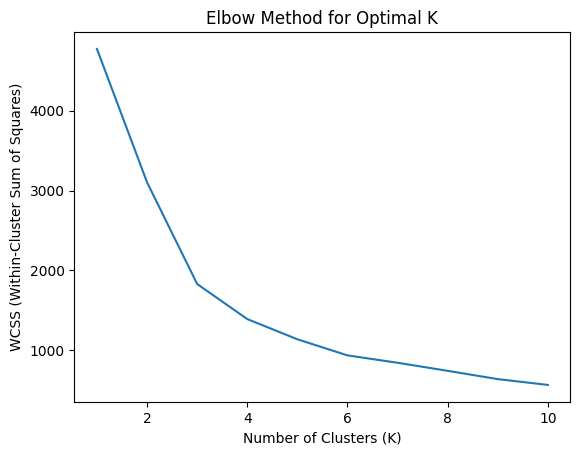

In [10]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

filtered_df = pd.read_csv('C:/Users/Feuer_Frei/Desktop/DataGeospatial_After_Q5.csv')

X = filtered_df[['latitude', 'longitude']]

wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    wcss.append(kmeans.inertia_)  

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

In [13]:
filtered_df

,taxi_id,timestamp,latitude,longitude,occupancy,location,speed_kmh,cluster
0,new_abboip,1211037083,37.75060,-122.42088,0,0101000020E610000097E2AAB2EF9A5EC055302AA913E0...,4.740746,1
1,new_abboip,1211037165,37.75054,-122.42087,0,0101000020E61000008577B988EF9A5EC0802BD9B111E0...,0.294918,1
2,new_abboip,1211039091,37.77156,-122.41834,1,0101000020E6100000F4A62215C69A5EC06D73637AC2E2...,1.042647,1
3,new_abboip,1211039151,37.77188,-122.41825,1,0101000020E610000054E3A59BC49A5EC0DF37BEF6CCE2...,2.183511,1
4,new_abboip,1211039228,37.77021,-122.41784,1,0101000020E61000007BBDFBE3BD9A5EC0AD86C43D96E2...,8.829069,1
...,...,...,...,...,...,...,...,...
5955064,new_uvreoipy,1211018644,37.78662,-122.40722,0,0101000020E6100000BC9179E40F9A5EC09430D3F6AFE4...,18.785332,0
5955065,new_uvreoipy,1211018715,37.78693,-122.40473,0,0101000020E6100000726DA818E7995EC0E21E4B1FBAE4...,11.257198,0
5955066,new_uvreoipy,1211018824,37.79134,-122.39927,0,0101000020E61000008811C2A38D995EC021020EA14AE5...,22.663866,0
5955067,new_uvreoipy,1211018889,37.78814,-122.39521,0,0101000020E61000005743E21E4B995EC0B05582C5E1E4...,27.915102,0


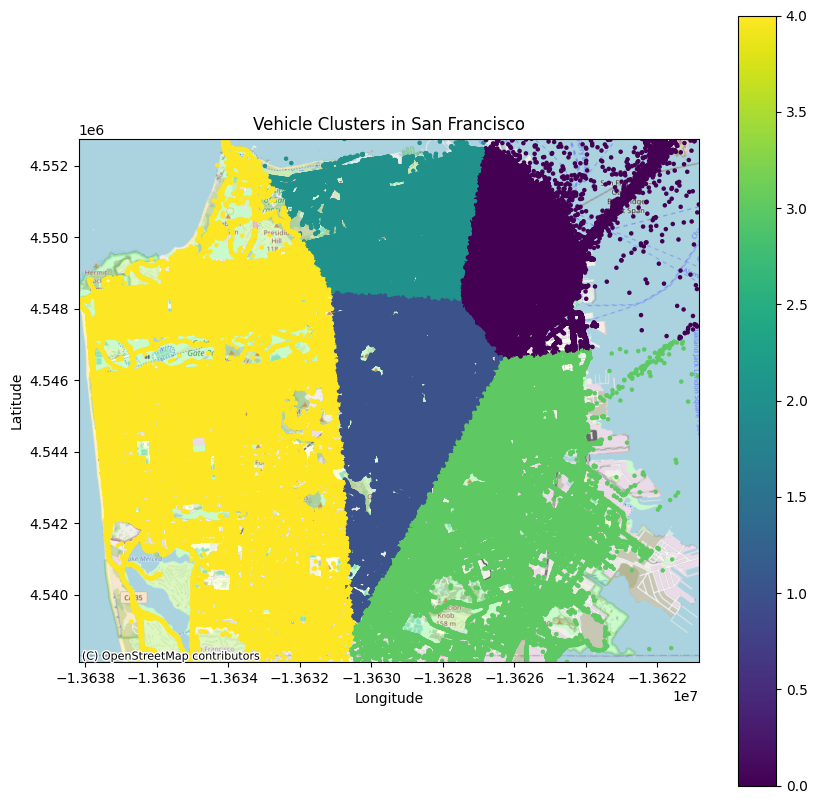

In [15]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import contextily as ctx  

X = filtered_df[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=5, random_state=0).fit(X)

filtered_df['cluster'] = kmeans.labels_

gdf1 = gpd.GeoDataFrame(filtered_df, geometry=gpd.points_from_xy(filtered_df['longitude'], filtered_df['latitude']), crs="EPSG:4326")

gdf1 = gdf1.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

gdf1.plot(column='cluster', ax=ax, legend=True, cmap='viridis', markersize=5)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

ax.set_xlim(gdf1.total_bounds[[0, 2]])  
ax.set_ylim(gdf1.total_bounds[[1, 3]])

plt.title('Vehicle Clusters in San Francisco')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()